In [3]:
from sklearn.cluster import KMeans
import pandas as pd

# Ladda engelska data
df = pd.read_csv("../data/cleaned_data.csv")

# Ta bara rader med GPS
df_geo = df.dropna(subset=["Lat_WGS84", "Lon_WGS84"]).copy()

# Kör KMeans med t.ex. 100 kluster
kmeans = KMeans(n_clusters=100, random_state=42)
df_geo["Cluster_ID"] = kmeans.fit_predict(df_geo[["Lat_WGS84", "Lon_WGS84"]])

# Lägg tillbaka kluster till hela datan
df = df.merge(df_geo[["Lat_WGS84", "Lon_WGS84", "Cluster_ID"]], on=["Lat_WGS84", "Lon_WGS84"], how="left")

In [6]:
df["Hour"] = pd.to_datetime(df["Time"], errors="coerce").dt.hour


In [9]:
# Grupp per kluster + timme
risk_counts = df.groupby(["Cluster_ID", "Hour"]).size().reset_index(name="collision_count")

# Sätt gräns – t.ex. top 20% = High Risk
threshold = risk_counts["collision_count"].quantile(0.80)
risk_counts["High_Risk"] = (risk_counts["collision_count"] >= threshold).astype(int)

# Lägg in i huvuddata
df = df.merge(risk_counts[["Cluster_ID", "Hour", "High_Risk"]], on=["Cluster_ID", "Hour"], how="left")

# Droppa alla som inte fick någon risknivå (t.ex. saknade tid eller kluster)
df = df.dropna(subset=["High_Risk"])

In [15]:
df.to_csv("../data/cleaned_with_clusters.csv", index=False)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Feature set (du kan justera!)
features = ["Cluster_ID", "Hour", "Month", "Weekday"]
target = "High_Risk"

# One-hot encode 'Weekday'
df_encoded = pd.get_dummies(df[features], columns=["Weekday"], drop_first=True)

# Splitta
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded, df[target], test_size=0.3, random_state=42
)

In [11]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

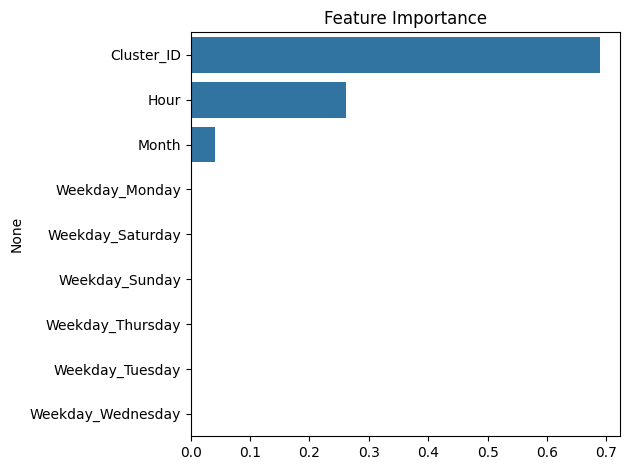

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
feature_names = X_train.columns

sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [13]:
import pickle

# Spara modellen
with open("../model/model.pkl", "wb") as f:
    pickle.dump(model, f)

# Spara kolumner (så vi kan transformera användardata rätt i appen)
with open("../model/model_columns.pkl", "wb") as f:
    pickle.dump(X_train.columns.tolist(), f)